<a href="https://colab.research.google.com/github/FrancescaTorazzi/jellyfish_classification-/blob/main/DeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from d2l import torch as d2l

ModuleNotFoundError: No module named 'd2l'

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
zip_path = "/content/drive/MyDrive/JellyfishDataset/archive.zip"

In [3]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

In [ ]:

import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm
import torch.optim as optim
from d2l import torch as d2l
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [4]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/JellyfishDataset/archive.zip"  # <-- Verifica il percorso corretto
extract_path = "/content/dataset"  # Dove estrarre i file

# Estrazione dello ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File extracted in:", extract_path)


File extracted in: /content/dataset


In [5]:
print(os.listdir(extract_path))

['Train_Test_Valid', 'mauve_stinger_jellyfish', 'blue_jellyfish', 'Moon_jellyfish', 'barrel_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish']


Eliminazione della cartella Trail_valid_test

In [6]:
import shutil

# Percorso della cartella da eliminare
remove_path = os.path.join(extract_path, "Train_Test_Valid")

# Verifica se la cartella esiste ed eliminala
if os.path.exists(remove_path):
    shutil.rmtree(remove_path)
    print("Cartella 'Train_Test_Valid' rimossa con successo!")
else:
    print("La cartella 'Train_Test_Valid' non era presente.")

Cartella 'Train_Test_Valid' rimossa con successo!


In [7]:
from collections import Counter

# Conta i file in ogni sottocartella
data_dirs = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
file_counts = {d: len(os.listdir(os.path.join(extract_path, d))) for d in data_dirs}

print("Number of images for species:")
print(file_counts)

Number of images for species:
{'mauve_stinger_jellyfish': 150, 'blue_jellyfish': 150, 'Moon_jellyfish': 150, 'barrel_jellyfish': 150, 'compass_jellyfish': 150, 'lions_mane_jellyfish': 150}


Dataset Description

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

dataset_path = "/content/dataset"
data = []

for root, _, files in os.walk(dataset_path):
    for image_name in files:
        if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(root, image_name)
            with Image.open(image_path) as img:
                width, height = img.size
                aspect = width / height
                data.append({'width': width, 'height': height, 'aspect_ratio': aspect})

df = pd.DataFrame(data)
print(df.describe())


            width      height  aspect_ratio
count  900.000000  900.000000         900.0
mean   210.600000  210.600000           1.0
std     20.589099   20.589099           0.0
min    179.000000  179.000000           1.0
25%    179.000000  179.000000           1.0
50%    224.000000  224.000000           1.0
75%    224.000000  224.000000           1.0
max    224.000000  224.000000           1.0


**Dataset description**:

- **Total Images:** The dataset consists of 900 images.
- **Uniform Aspect Ratio:** The `aspect_ratio` is consistently 1.0 for all images, which means every image is square (width equals height).
- **Dimensions Distribution:**  
  - The minimum image size is 179×179 pixels, and the maximum is 224×224 pixels.  
  - The mean dimensions are approximately 210.6×210.6 pixels, with a standard deviation of about 20.59 pixels.  
  - The 25th percentile is 179 pixels, while both the 50th (median) and 75th percentiles are 224 pixels, indicating that a significant portion of the dataset (more than 50%) comprises images at the maximum size.

The dataset is homogeneous in terms of size and shape therefore variability in image dimensions or aspect ratios is low.


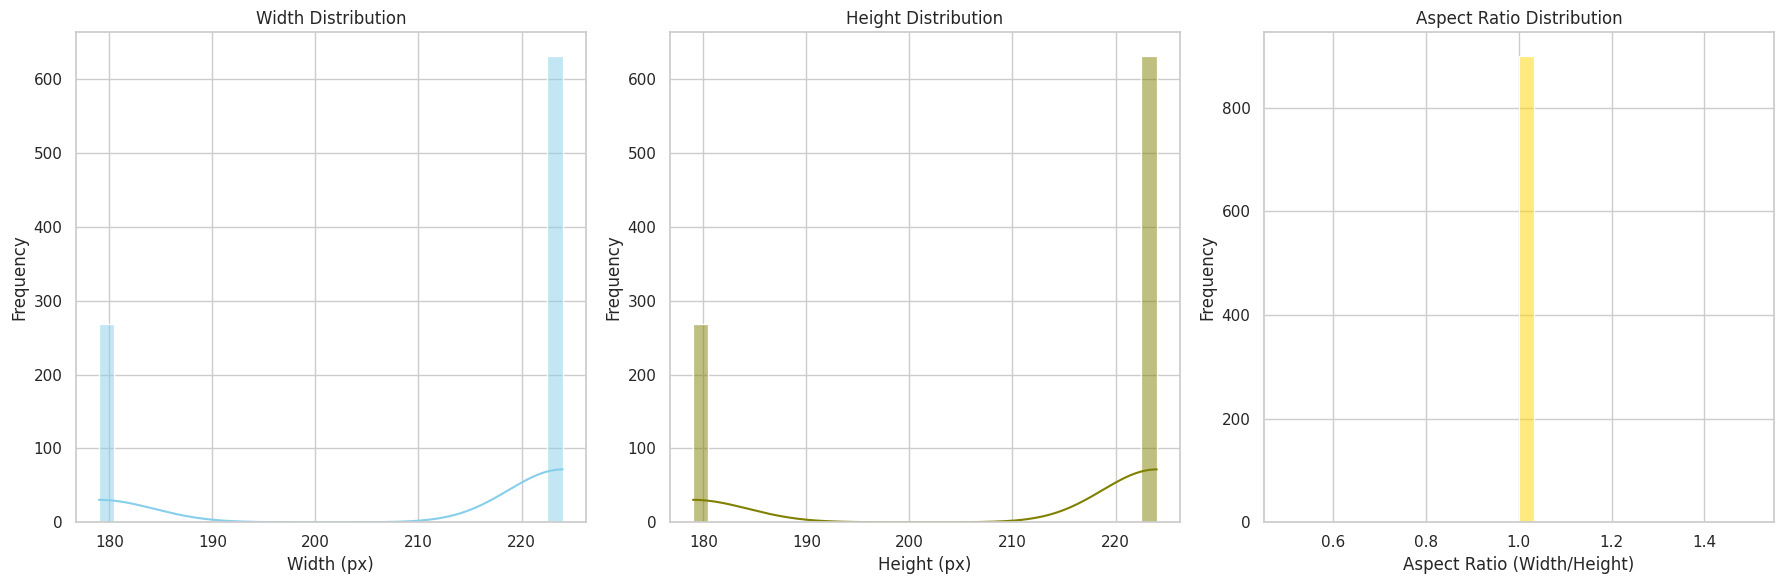

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(18, 6))

# Histogram for Widths
plt.subplot(1, 3, 1)
sns.histplot(df['width'], bins=30, kde=True, color="skyblue")
plt.title('Width Distribution')
plt.xlabel('Width (px)')
plt.ylabel('Frequency')

# Histogram for Heights
plt.subplot(1, 3, 2)
sns.histplot(df['height'], bins=30, kde=True, color="olive")
plt.title('Height Distribution')
plt.xlabel('Height (px)')
plt.ylabel('Frequency')

# Histogram for Aspect Ratios
plt.subplot(1, 3, 3)
sns.histplot(df['aspect_ratio'], bins=30, kde=True, color="gold")
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



**Width Distribution**  
This histogram shows that the images in the dataset have two dominant width values: 179 px and 224 px. The bars indicate a bimodal distribution, where a subset of images is clustered around 179 px, while another large group is around 224 px.

**Height Distribution**  
Similarly, the height histogram reveals the same pattern: most images are either 179 px or 224 px in height. This mirrors the width distribution and further confirms that the dataset primarily contains images of two distinct sizes.

**Aspect Ratio Distribution**  
All images have an aspect ratio of exactly 1.0, meaning they are square. The single, tall bar at 1.0 indicates there is no variation in width-to-height ratio across the dataset.

In summary two clear clusters appear at (179, 179) and (224, 224). This indicates that the dataset comprises square images of these two specific dimensions, reinforcing the observations from the histograms.

In [ ]:
import shutil
import os

folder_to_remove = os.path.join(dataset_path, 'Train_Test_Valid')

if os.path.exists(folder_to_remove):
    shutil.rmtree(folder_to_remove)
    print(f"Cartella {folder_to_remove} eliminata definitivamente.")
else:
    print("Cartella già rimossa.")

Cartella già rimossa.


In [11]:
print("Classi trovate nel dataset:", os.listdir(dataset_path))

Classi trovate nel dataset: ['mauve_stinger_jellyfish', 'blue_jellyfish', 'Moon_jellyfish', 'barrel_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish']


Label counts: {'mauve_stinger_jellyfish': 150, 'blue_jellyfish': 150, 'Moon_jellyfish': 150, 'barrel_jellyfish': 150, 'compass_jellyfish': 150, 'lions_mane_jellyfish': 150}


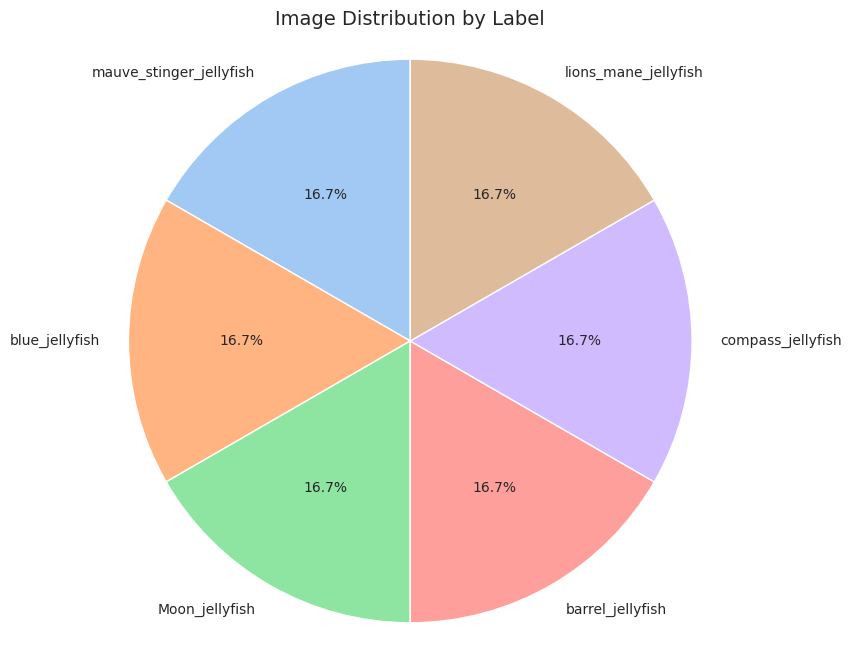

In [12]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your dataset
dataset_path = "/content/dataset"

# Dictionary to count images per label
label_counts = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    # Exclude the 'Train_Test_Valid' folder and only consider directories
    if os.path.isdir(label_path) and label != 'Train_Test_Valid':
        # Count how many image files are in this folder (not recursively)
        num_images = len([f for f in os.listdir(label_path)
                          if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        label_counts[label] = num_images

# Check if there are any labels
if not label_counts:
    raise ValueError("No labels found in the dataset path.")

# Print out the counts for debugging
print("Label counts:", label_counts)

# --- PLOT SETTINGS ---
# We'll use Seaborn's 'pastel' palette for a nicer look
sns.set_style("whitegrid")
colors = sns.color_palette("pastel", len(label_counts))

plt.figure(figsize=(8, 8))
# Create the pie chart
wedges, texts, autotexts = plt.pie(
    label_counts.values(),
    labels=label_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

# Make the text more readable
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)

plt.title('Image Distribution by Label', fontsize=14)
plt.axis('equal')

plt.show()


In [13]:
os.listdir(dataset_path)

['mauve_stinger_jellyfish',
 'blue_jellyfish',
 'Moon_jellyfish',
 'barrel_jellyfish',
 'compass_jellyfish',
 'lions_mane_jellyfish']

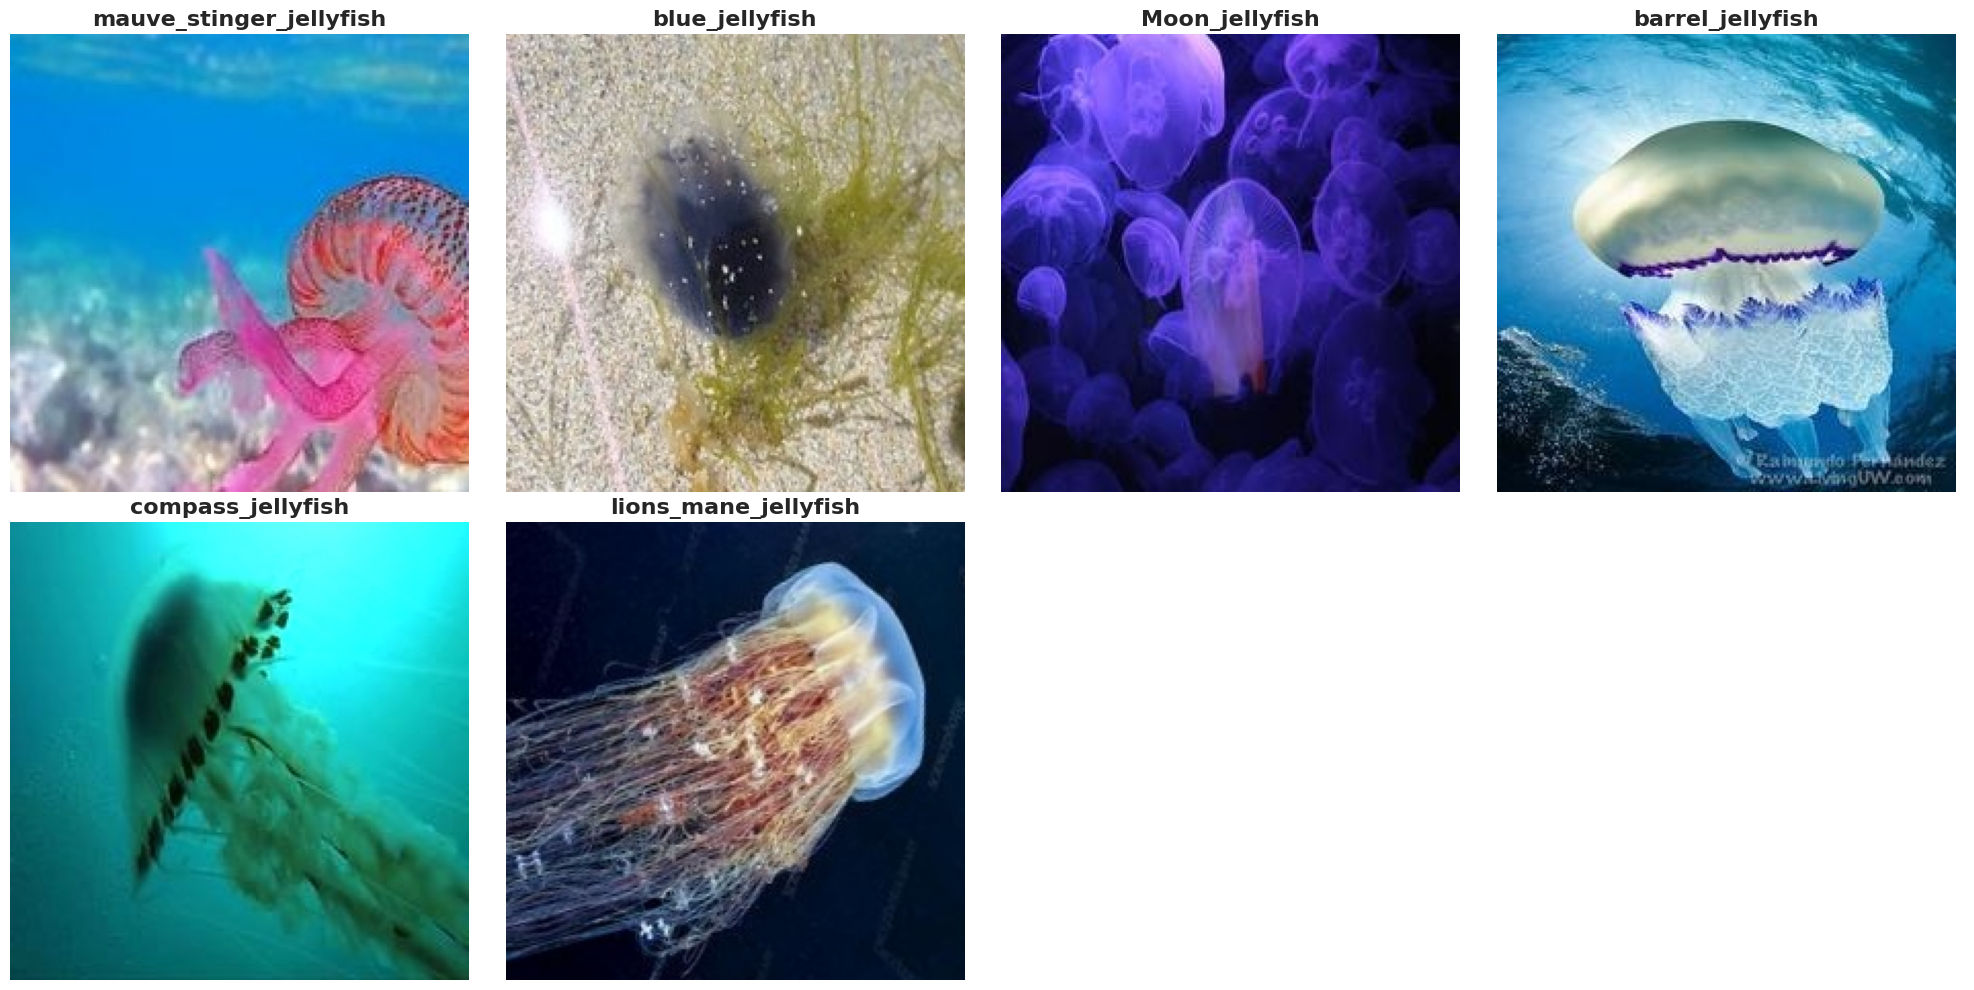

In [14]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


# Crea un dizionario con le immagini per ciascuna categoria (sottocartella)
category_to_images = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):  # Verifica che sia una cartella
        category_to_images[label] = [file for file in os.listdir(label_path) if file.endswith(('.jpg', '.png', '.jpeg'))]

# Verifica se ci sono categorie
if not category_to_images:
    raise ValueError("No categories found in the dataset path.")

# Imposta un seme per la riproducibilità
random.seed(123)

# Seleziona un'immagine casuale per ciascuna categoria
random_images = {}
for category, images in category_to_images.items():
    if images:  # Assicurati che ci siano immagini per la categoria
        random_images[category] = random.choice(images)

# Configura i plot
num_categories = len(random_images)
rows = (num_categories + 3) // 4  # Calcola dinamicamente il numero di righe per il grafico
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten()

# Visualizza le immagini
for ax, (category, image_name) in zip(axes, random_images.items()):
    image_path = os.path.join(dataset_path, category, image_name)
    try:
        with Image.open(image_path) as img:
            ax.imshow(img)
            ax.set_title(category, fontsize=16, fontweight='bold')
            ax.axis('off')  # Nascondi gli assi per un aspetto più pulito
    except FileNotFoundError:
        ax.set_title(f"Missing: {category}", fontsize=16, fontweight='bold')
        ax.axis('off')  # Nascondi gli assi per le immagini mancanti

# Nascondi gli assi inutilizzati
for ax in axes[len(random_images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


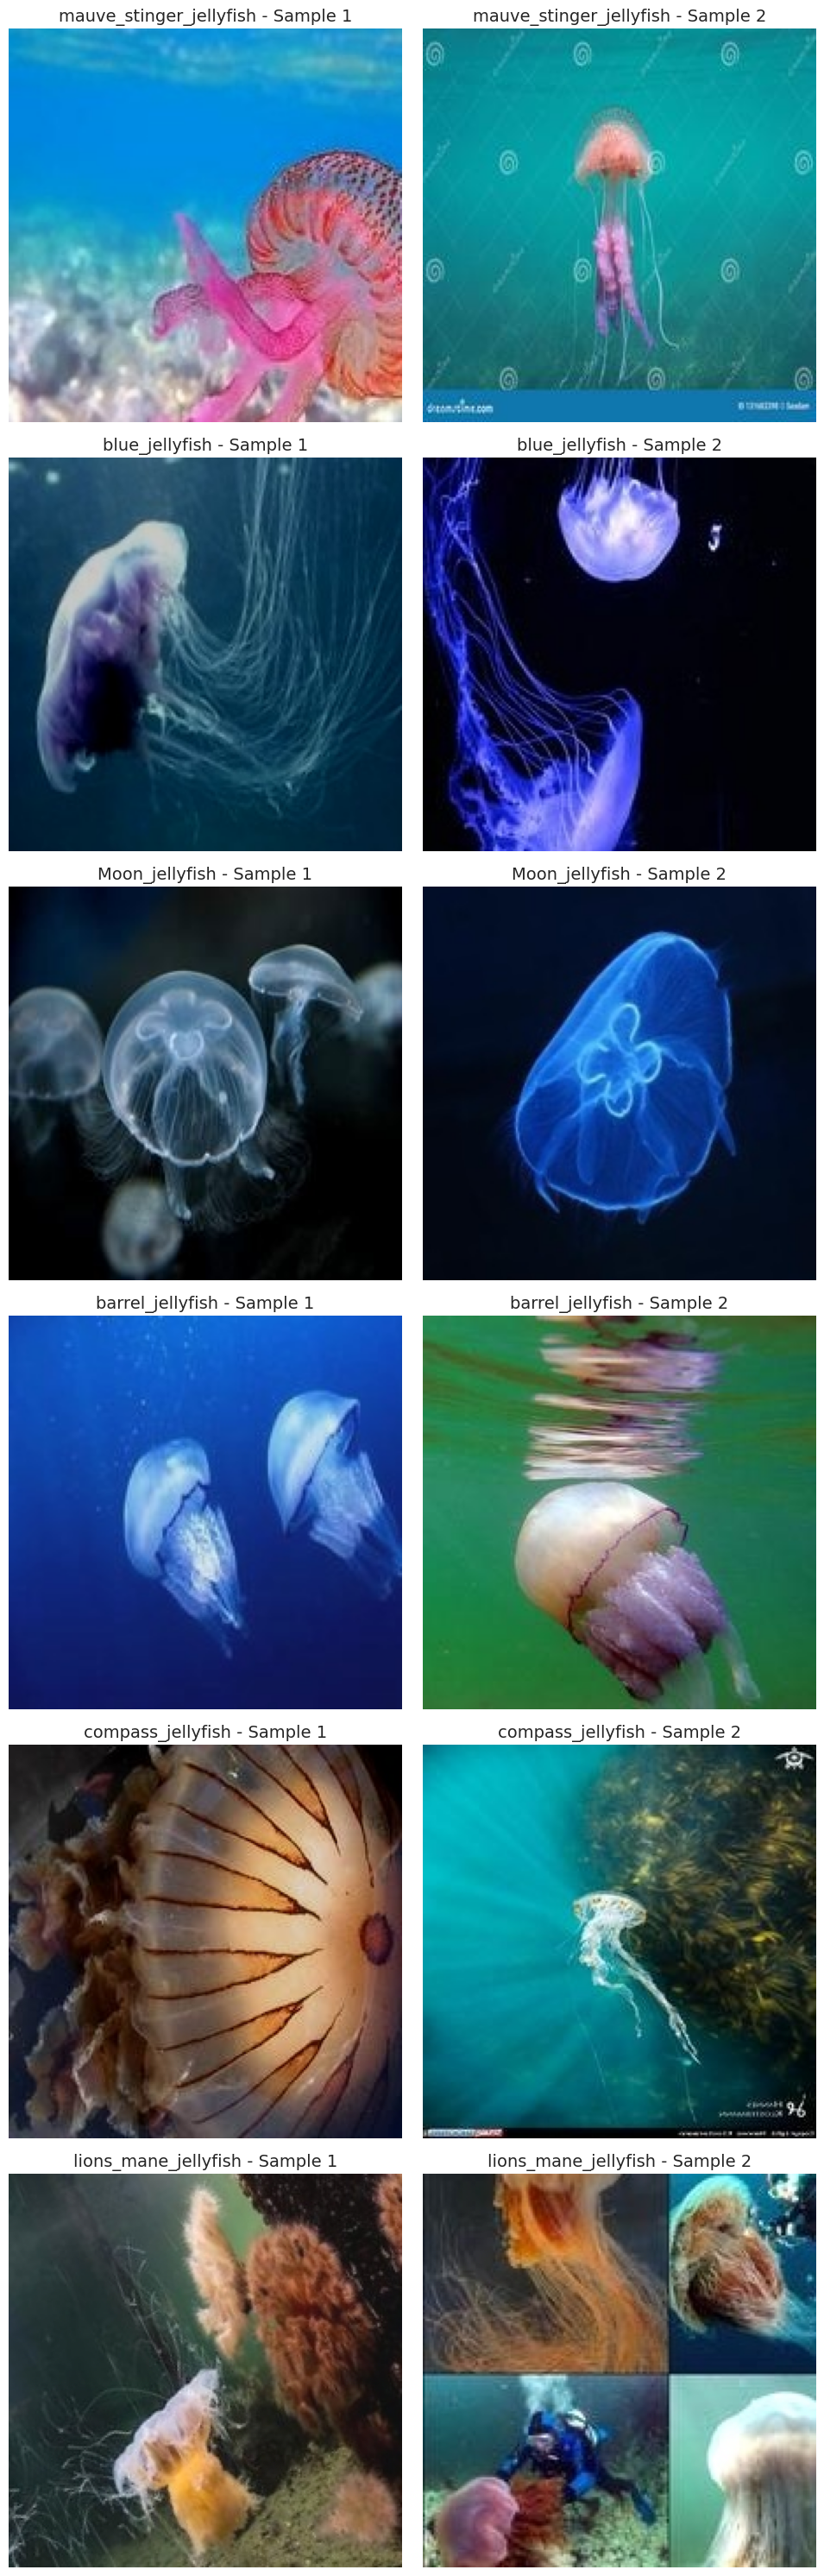

In [15]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Specify the path to your dataset
dataset_path = "/content/dataset"

# Create a dictionary mapping each category (subfolder) to its list of image files
category_to_images = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    # Check if it's a directory
    if os.path.isdir(label_path):
        # Gather all image files in this directory (non-recursive)
        category_to_images[label] = [
            file for file in os.listdir(label_path)
            if file.lower().endswith(('.jpg', '.png', '.jpeg'))
        ]

# Raise an error if no categories are found
if not category_to_images:
    raise ValueError("No categories found in the dataset path.")

# Set a random seed for reproducibility
random.seed(123)

# For each category, select 2 random images (if available)
random_images = {}
for category, images in category_to_images.items():
    if len(images) >= 2:
        random_images[category] = random.sample(images, 2)
    elif images:
        random_images[category] = images  # If only one image is available, use it

# Determine the number of categories
num_categories = len(random_images)

# Create a subplot grid with each row representing a category and 2 columns for the two samples
fig, axes = plt.subplots(num_categories, 2, figsize=(10, 5 * num_categories))

# If there's only one category, ensure axes is a 2D array
if num_categories == 1:
    axes = [axes]

# Display the images for each category
for row_idx, (category, image_names) in enumerate(random_images.items()):
    for col_idx in range(2):
        ax = axes[row_idx][col_idx] if num_categories > 1 else axes[col_idx]
        if col_idx < len(image_names):
            image_path = os.path.join(dataset_path, category, image_names[col_idx])
            try:
                with Image.open(image_path) as img:
                    ax.imshow(img)
                    ax.set_title(f"{category} - Sample {col_idx + 1}", fontsize=14)
            except Exception as e:
                ax.text(0.5, 0.5, f"Error loading image:\n{e}", ha='center', va='center')
        else:
            # Hide the subplot if there isn't a second image
            ax.axis('off')
        ax.axis('off')  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()


**Loading of the dataset**

Cosa si fa in questo blocco:

1. **Definisce la funzione `get_dataloader_workers()`**: Restituisce il numero di CPU per il caricamento parallelo dei dati.
2. **Definisce la funzione `data_loader()`**: Carica il dataset, applica trasformazioni, suddivide in training, validazione e test, e crea i DataLoader.
3. **Verifica normalizzazione**: Controlla se i parametri `mean` e `std` sono forniti per la normalizzazione.
4. **Trasformazioni di base**: Ridimensiona, converte in tensori e normalizza le immagini.
5. **Caricamento dataset con `ImageFolder()`**: Carica immagini e etichette basate sulla struttura delle sottocartelle.
6. **Suddivisione in training, validazione e test**: Usa `random_split()` per dividere il dataset.
7. **Augmentazione (opzionale)**: Applica trasformazioni di aumentazione solo al training set se richiesto.
8. **Creazione dei DataLoader**: Crea i DataLoader per il training, la validazione e il test, con parallelismo e batching.
9. **Ritorna i DataLoader**: Restituisce i DataLoader pronti per il training.

In [16]:
from torchvision import datasets, transforms
import torch
import numpy as np
from tqdm import tqdm


# Definisci la trasformazione per caricare le immagini (solo la conversione a tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona le immagini
    transforms.ToTensor()           # Converte le immagini in tensori
])

# Carica il dataset senza normalizzazione per calcolare la media e la deviazione standard
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Funzione per calcolare la media e la deviazione standard
def calculate_mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = len(dataset)

    # Usa tqdm per un progresso visivo
    for img, _ in tqdm(dataset):
        mean += img.mean(dim=[1, 2])  # Calcola la media per ogni canale
        std += img.std(dim=[1, 2])    # Calcola la deviazione standard per ogni canale

    mean /= total_images
    std /= total_images
    return mean, std

mean, std = calculate_mean_std(dataset)

print("Mean:", mean)
print("Std:", std)


100%|██████████| 900/900 [00:02<00:00, 420.59it/s]


Mean: tensor([0.2614, 0.3639, 0.4199])
Std: tensor([0.1937, 0.1780, 0.1946])


### Data Preprocessing and Normalization


- **Transformation Pipeline:**  
  The images are resized to 224×224 pixels (using `transforms.Resize((224, 224))`) and converted into tensors with `transforms.ToTensor()`. This standardizes all images, including those originally smaller than 224×224.

- **Dataset Loading:**  
  The `datasets.ImageFolder` function loads the images from the specified directory, automatically organizing them by class based on folder structure.

- **Mean and Standard Deviation Calculation:**  
  The `calculate_mean_std` function iterates through the dataset (with a progress bar via `tqdm`), computing the per-channel mean and standard deviation by aggregating these statistics from each image. The final values are averaged over the total number of images.

- **Purpose:**  
  These computed statistics can be used to normalize the dataset during training, which helps in faster convergence and improved model performance.

This compact pre-processing routine ensures that all input images are uniformly sized and properly normalized before being fed into the model.

In [17]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os
import torch
import numpy as np

# Example mean and std values for the dataset (replace with your computed values)
mean = [0.2614, 0.3639, 0.4199]
std = [0.1937, 0.1780, 0.1946]

# Function to get the number of workers for the DataLoader
def get_dataloader_workers():
    import os
    return os.cpu_count()

# Function to load the dataset and create DataLoaders for train, validation, and test sets
def data_loader(dataset_path,
                batch_size,
                height, width,
                augmentation=False,
                train_perc=0.7, val_perc=0.2,
                seed=123,
                mean=None, std=None):

    # Set seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Check that mean and std are provided
    if mean is None or std is None:
        raise ValueError("Mean and Std must be provided for normalization.")

    # Basic transformation: resize, convert to tensor, and normalize
    trans = transforms.Compose([
        transforms.Resize((height, width)),  # Resize images to (height, width)
        transforms.ToTensor(),               # Convert images to tensors
        transforms.Normalize(mean=mean, std=std)  # Normalize images using provided mean and std
    ])

    # Load the dataset using ImageFolder (automatically organizes images by subfolder)
    dataset = datasets.ImageFolder(root=dataset_path, transform=trans)

    # Compute the dataset size
    dataset_size = len(dataset)
    train_size = int(train_perc * dataset_size)
    val_size = int(val_perc * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset into training, validation, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # If augmentation is enabled, apply it only to the training set
    if augmentation:
        data_augmentation = transforms.Compose([
            transforms.Resize((height, width)),  # Resize images to (height, width)

            # Apply random data augmentation transformations
            transforms.RandomApply([transforms.RandomRotation(degrees=20)], p=0.5),
            transforms.RandomApply([transforms.RandomHorizontalFlip(p=1.0)], p=0.5),
            transforms.RandomApply([transforms.RandomVerticalFlip(p=1.0)], p=0.5),
            transforms.RandomApply([transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0))], p=0.5),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)], p=0.5),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5),

            transforms.ToTensor(),  # Convert images to tensors
            transforms.Normalize(mean=mean, std=std)  # Normalize images
        ])

        # Replace the training dataset's transform with the data augmentation transform
        train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=data_augmentation)

    # Create DataLoaders for the training, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers())
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return dataset, train_loader, val_loader, test_loader

# Load the dataset with the specified parameters (batch_size, height, width, augmentation, mean, std)
dataset, train_loader, val_loader, test_loader = data_loader(
    dataset_path=dataset_path,
    batch_size=64,
    height=224,
    width=224,
    augmentation=True,
    mean=mean,
    std=std
)

# Print the sizes of the datasets to confirm the split
print(f'Train set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')



Train set size: 630
Validation set size: 180
Test set size: 90


**Visualization of a batch**



- **Batch Representation:**  
  The batch is a tensor of shape `(batch_size, channels, height, width)` extracted from the training DataLoader. It represents a group of images that are processed simultaneously during model training.

- **Visualization:**  
  The code uses `make_grid` to arrange the batch images into a grid, making it easier to visually inspect the quality and verify that the preprocessing steps (such as resizing, normalization, and data augmentation) have been applied correctly.

- **Denormalization:**  
  The `imshow` function denormalizes the images (by reversing the normalization transformation) before displaying them, ensuring that the displayed images reflect their original appearance.

---

Train set size: 630
Validation set size: 180
Test set size: 90


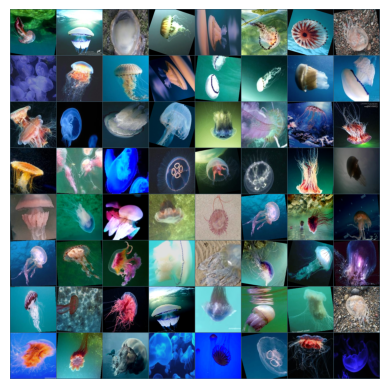

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.utils import make_grid

# Function to denormalize and display an image tensor
def imshow(img, mean, std):
    """
    Denormalize and display an image tensor.

    Args:
        img (Tensor): Image tensor of shape (C, H, W)
        mean (list): List of mean values for each channel
        std (list): List of standard deviation values for each channel
    """
    # Clone the tensor to avoid modifying the original image
    img_denorm = img.clone()

    # Denormalize each channel: reverse the normalization transformation
    for i in range(3):  # Assuming 3 channels (RGB)
        img_denorm[i] = img_denorm[i] * std[i] + mean[i]

    # Convert tensor to numpy array and transpose dimensions for display
    npimg = img_denorm.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axis for a cleaner look
    plt.show()

# Print dataset sizes for confirmation
print(f'Train set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

# Get a batch of images from the training DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of images and display it
grid = make_grid(images)
imshow(grid, mean, std)


**Inceptions**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()

        self.path1 = nn.Sequential(
            nn.Conv2d(input_channels, c1, kernel_size=1),
            nn.BatchNorm2d(c1),
        )

        # Path 2: 1x1 -> 3x3 Convolution
        self.path2_1 = nn.Sequential(
            nn.Conv2d(input_channels, c2[0], kernel_size=1),
            nn.BatchNorm2d(c2[0]),
        )
        self.path2_2 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1]),
        )

        # Path 3: 1x1 -> 5x5 Convolution
        self.path3_1 = nn.Sequential(
            nn.Conv2d(input_channels, c3[0], kernel_size=1),
            nn.BatchNorm2d(c3[0]),
        )
        self.path3_2 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1]),
        )

        # Path 4: Max Pooling -> 1x1 Convolution
        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Sequential(
            nn.Conv2d(input_channels, c4, kernel_size=1),
            nn.BatchNorm2d(c4),
        )

    def forward(self, x):
        p1 = F.leaky_relu(self.path1(x))
        p2 = F.leaky_relu(self.path2_2(self.path2_1(x)))
        p3 = F.leaky_relu(self.path3_2(self.path3_1(x)))
        p4 = F.leaky_relu(self.path4_2(self.path4_1(x)))
        output = torch.cat((p1, p2, p3, p4), dim=1)
        return output


The steps implemented in the Inception module for GoogLeNet are:

1. **Branch 1 (Path1):**  
   - Applies a 1x1 convolution to reduce dimensionality.  
   - Follows up with batch normalization.  
   - Uses ReLU as the activation function on the output.

2. **Branch 2 (Path2):**  
   - Starts with a 1x1 convolution to reduce dimensionality, followed by batch normalization.  
   - Then applies a 3x3 convolution (with padding=1 to preserve spatial dimensions) and batch normalization.  
   - The output is passed through ReLU.

3. **Branch 3 (Path3):**  
   - Begins with a 1x1 convolution to reduce the number of channels, followed by batch normalization.  
   - A 5x5 convolution (with padding=2 for spatial consistency) is applied next, along with batch normalization.  
   - The branch output is activated using ReLU.

4. **Branch 4 (Path4):**  
   - Utilizes a 3x3 max pooling operation (with stride=1 and padding=1) to capture local features.  
   - Applies a 1x1 convolution and batch normalization to the pooled output.  
   - The resulting features are activated with ReLU.

5. **Concatenation:**  
   - The outputs from all four branches are concatenated along the channel dimension. This combined output forms the final result of the Inception module.

These steps ensure that each branch processes the input with different receptive fields and that the final module benefits from multi-scale feature extraction, a key aspect of GoogLeNet's architecture.

**Blocks GoogLeNet**

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definition of the Inception module using LeakyReLU activations
class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()

        # Branch 1: 1x1 Convolution
        self.path1 = nn.Sequential(
            nn.Conv2d(input_channels, c1, kernel_size=1),
            nn.BatchNorm2d(c1),
        )

        # Branch 2: 1x1 Convolution followed by 3x3 Convolution
        self.path2_1 = nn.Sequential(
            nn.Conv2d(input_channels, c2[0], kernel_size=1),
            nn.BatchNorm2d(c2[0]),
        )
        self.path2_2 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1]),
        )

        # Branch 3: 1x1 Convolution followed by 5x5 Convolution
        self.path3_1 = nn.Sequential(
            nn.Conv2d(input_channels, c3[0], kernel_size=1),
            nn.BatchNorm2d(c3[0]),
        )
        self.path3_2 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1]),
        )

        # Branch 4: Max Pooling followed by 1x1 Convolution
        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Sequential(
            nn.Conv2d(input_channels, c4, kernel_size=1),
            nn.BatchNorm2d(c4),
        )

    def forward(self, x):
        # Use LeakyReLU for all branches
        p1 = F.leaky_relu(self.path1(x))
        p2 = F.leaky_relu(self.path2_2(self.path2_1(x)))
        p3 = F.leaky_relu(self.path3_2(self.path3_1(x)))
        p4 = F.leaky_relu(self.path4_2(self.path4_1(x)))
        # Concatenate outputs along the channel dimension
        output = torch.cat((p1, p2, p3, p4), dim=1)
        return output

# Block 1: Initial convolution and pooling layers
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),  # Using LeakyReLU activation
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.1)
)

# Block 2: Additional convolutional layers with pooling
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),  # Using LeakyReLU activation
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.BatchNorm2d(192),
    nn.LeakyReLU(),  # Using LeakyReLU activation
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.2)
)

# Block 3: Inception modules followed by pooling
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.3)
)

# Block 4: Additional Inception modules with pooling
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.3)
)

# Block 5: Final Inception modules, global pooling, and dropout
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Dropout(p=0.4)
)

# Complete network: Stacking all blocks followed by a fully connected layer
num_classes = 6  # Adjust according to the number of classes in your dataset
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.Linear(1024, num_classes)
)

# Print the network architecture
print(net)

#data augmentation riscalare l'immagine
#14.1 image augmentation
#computer vision cap 13.1


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Inception(
      (path1): Sequential(
        (0): Conv2d(192, 64, kern


**Network Architecture Explanation**

The implemented network is inspired by the GoogLeNet architecture and is composed of several blocks that progressively extract and refine features from the input images. Key components include:

- **Inception Module:**  
  The core building block is the Inception module, which processes the input through four parallel paths:
  1. **Path 1:** A 1×1 convolution reduces dimensionality, followed by batch normalization and a ReLU activation.
  2. **Path 2:** Begins with a 1×1 convolution (and batch normalization) to reduce dimensions, followed by a 3×3 convolution (with padding to preserve spatial size) and another batch normalization, with ReLU applied at the end.
  3. **Path 3:** Similar to path 2, but uses a 5×5 convolution (with padding) after an initial 1×1 convolution, batch normalization, and a ReLU activation.
  4. **Path 4:** Applies a 3×3 max pooling (with stride 1 and padding) followed by a 1×1 convolution and batch normalization, with the output activated by ReLU.
  
  The outputs from these four branches are concatenated along the channel dimension, allowing the module to capture features at multiple scales.

- **Overall Network Blocks:**  
  The network is organized into five main blocks:
  - **Block 1:** Performs an initial feature extraction using a 7×7 convolution, batch normalization, ReLU activation, max pooling, and dropout. This block reduces the spatial dimensions while increasing the number of feature channels.
  - **Block 2:** Contains additional convolutional layers with ReLU activations and pooling, further refining the feature maps.
  - **Block 3 & Block 4:** These blocks consist of multiple Inception modules. They progressively extract more complex and abstract features while reducing spatial dimensions using pooling and applying dropout for regularization.
  - **Block 5:** The final block uses adaptive average pooling to aggregate features globally, followed by flattening and dropout before passing the output to a fully connected layer.

- **Final Classification:**  
  The last layer is a linear (fully connected) layer that maps the flattened feature vector to the desired number of classes (6 in this case).

The code below tests the forward pass through the layers of the network by feeding a randomly generated input tensor 𝑋 of shape (1, 3, 224, 224), which simulates a single RGB image resized to 224×224 pixels.

Purpose: The loop iterates over each layer of the network (net), processes the input through the layer, and prints the layer's class name along with the shape of its output.

It helps verify how the spatial dimensions and channel sizes evolve as the data flows through the network. Useful for debugging or ensuring the network architecture behaves as expected.

In [21]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape' ,X.shape)

Sequential output shape torch.Size([1, 64, 56, 56])
Sequential output shape torch.Size([1, 192, 28, 28])
Sequential output shape torch.Size([1, 480, 14, 14])
Sequential output shape torch.Size([1, 832, 7, 7])
Sequential output shape torch.Size([1, 1024])
Linear output shape torch.Size([1, 6])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

def accuracy(y_hat, y):
    """Calcola l'accuratezza delle predizioni."""
    preds = torch.argmax(y_hat, dim=1)
    return (preds == y).float().mean().item()

def train(net, train_loader, val_loader, test_loader, num_epochs, lr, weight_decay=1e-4, device=None):
    """
    Allena un modello con GPU (se disponibile).
    """

    # Se il device non è specificato, prova a usare la GPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Xavier initialization
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print(f'Training on {device}')

    net.to(device)  # Sposta il modello su GPU (se disponibile)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        net.train()
        epoch_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X.size(0)
            correct += (y_hat.argmax(1) == y).sum().item()
            total += X.size(0)

            progress_bar.set_postfix(loss=epoch_loss / total, acc=correct / total)

        # Validazione dopo ogni epoca
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += loss_fn(y_hat, y).item() * X.size(0)
                val_correct += (y_hat.argmax(1) == y).sum().item()
                val_total += X.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}: Train Loss={epoch_loss/total:.4f}, Train Acc={correct/total:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Salvataggio del modello finale
    torch.save(net.state_dict(), 'Jellyfish_Inception.pth')
    print("Modello finale salvato come 'Jellyfish_Inception.pth'")

    return net


In [ ]:
train(net, train_loader, val_loader, test_loader, num_epochs=50, lr=0.01)

Training on cpu


Epoch 1/50: 100%|██████████| 10/10 [04:11<00:00, 25.17s/it, acc=0.19, loss=2.46]


Epoch 1: Train Loss=2.4618, Train Acc=0.1905, Val Loss=1.7998, Val Acc=0.1722


Epoch 2/50: 100%|██████████| 10/10 [04:11<00:00, 25.20s/it, acc=0.248, loss=1.95]


Epoch 2: Train Loss=1.9535, Train Acc=0.2476, Val Loss=1.7512, Val Acc=0.2333


Epoch 3/50: 100%|██████████| 10/10 [04:02<00:00, 24.30s/it, acc=0.311, loss=1.74]


Epoch 3: Train Loss=1.7402, Train Acc=0.3111, Val Loss=2.2929, Val Acc=0.3444


Epoch 4/50: 100%|██████████| 10/10 [04:00<00:00, 24.02s/it, acc=0.356, loss=1.53]


Epoch 4: Train Loss=1.5305, Train Acc=0.3556, Val Loss=2.0752, Val Acc=0.3722


Epoch 5/50: 100%|██████████| 10/10 [04:00<00:00, 24.07s/it, acc=0.375, loss=1.53]


Epoch 5: Train Loss=1.5277, Train Acc=0.3746, Val Loss=1.6646, Val Acc=0.3444


Epoch 6/50: 100%|██████████| 10/10 [04:02<00:00, 24.26s/it, acc=0.392, loss=1.55]


Epoch 6: Train Loss=1.5539, Train Acc=0.3921, Val Loss=1.5417, Val Acc=0.4111


Epoch 7/50: 100%|██████████| 10/10 [04:02<00:00, 24.23s/it, acc=0.376, loss=1.53]


Epoch 7: Train Loss=1.5314, Train Acc=0.3762, Val Loss=1.5317, Val Acc=0.3222


Epoch 8/50: 100%|██████████| 10/10 [04:00<00:00, 24.08s/it, acc=0.395, loss=1.49]


Epoch 8: Train Loss=1.4870, Train Acc=0.3952, Val Loss=1.4924, Val Acc=0.4333


Epoch 9/50: 100%|██████████| 10/10 [04:00<00:00, 24.03s/it, acc=0.43, loss=1.46]


Epoch 9: Train Loss=1.4572, Train Acc=0.4302, Val Loss=1.5068, Val Acc=0.3833


Epoch 10/50: 100%|██████████| 10/10 [04:01<00:00, 24.18s/it, acc=0.422, loss=1.46]


Epoch 10: Train Loss=1.4559, Train Acc=0.4222, Val Loss=1.6391, Val Acc=0.3556


Epoch 11/50: 100%|██████████| 10/10 [04:01<00:00, 24.13s/it, acc=0.444, loss=1.44]


Epoch 11: Train Loss=1.4364, Train Acc=0.4444, Val Loss=1.6197, Val Acc=0.2611


Epoch 12/50: 100%|██████████| 10/10 [04:01<00:00, 24.14s/it, acc=0.429, loss=1.52]


Epoch 12: Train Loss=1.5250, Train Acc=0.4286, Val Loss=1.6680, Val Acc=0.4056


Epoch 13/50: 100%|██████████| 10/10 [03:59<00:00, 23.93s/it, acc=0.465, loss=1.41]


Epoch 13: Train Loss=1.4145, Train Acc=0.4651, Val Loss=1.5405, Val Acc=0.3278


Epoch 14/50: 100%|██████████| 10/10 [04:02<00:00, 24.23s/it, acc=0.475, loss=1.41]


Epoch 14: Train Loss=1.4116, Train Acc=0.4746, Val Loss=1.4586, Val Acc=0.3722


Epoch 15/50: 100%|██████████| 10/10 [03:59<00:00, 23.94s/it, acc=0.448, loss=1.4]


Epoch 15: Train Loss=1.4004, Train Acc=0.4476, Val Loss=1.4840, Val Acc=0.3778


Epoch 16/50: 100%|██████████| 10/10 [04:03<00:00, 24.34s/it, acc=0.476, loss=1.34]


Epoch 16: Train Loss=1.3358, Train Acc=0.4762, Val Loss=1.4453, Val Acc=0.3722


Epoch 17/50: 100%|██████████| 10/10 [04:06<00:00, 24.66s/it, acc=0.479, loss=1.34]


Epoch 17: Train Loss=1.3371, Train Acc=0.4794, Val Loss=1.3907, Val Acc=0.4500


Epoch 18/50: 100%|██████████| 10/10 [04:07<00:00, 24.75s/it, acc=0.457, loss=1.29]


Epoch 18: Train Loss=1.2900, Train Acc=0.4571, Val Loss=1.5203, Val Acc=0.3833


Epoch 19/50: 100%|██████████| 10/10 [04:01<00:00, 24.19s/it, acc=0.473, loss=1.33]


Epoch 19: Train Loss=1.3288, Train Acc=0.4730, Val Loss=1.4767, Val Acc=0.3500


Epoch 20/50: 100%|██████████| 10/10 [04:00<00:00, 24.01s/it, acc=0.487, loss=1.27]


Epoch 20: Train Loss=1.2742, Train Acc=0.4873, Val Loss=1.4912, Val Acc=0.4278


Epoch 21/50: 100%|██████████| 10/10 [04:00<00:00, 24.01s/it, acc=0.498, loss=1.26]


Epoch 21: Train Loss=1.2560, Train Acc=0.4984, Val Loss=1.3953, Val Acc=0.4389


Epoch 22/50: 100%|██████████| 10/10 [03:58<00:00, 23.89s/it, acc=0.508, loss=1.21]


Epoch 22: Train Loss=1.2125, Train Acc=0.5079, Val Loss=1.6024, Val Acc=0.3000


Epoch 23/50: 100%|██████████| 10/10 [03:59<00:00, 23.98s/it, acc=0.532, loss=1.24]


Epoch 23: Train Loss=1.2444, Train Acc=0.5317, Val Loss=1.5481, Val Acc=0.3889


Epoch 24/50: 100%|██████████| 10/10 [04:04<00:00, 24.47s/it, acc=0.537, loss=1.2]


Epoch 24: Train Loss=1.1975, Train Acc=0.5365, Val Loss=1.5123, Val Acc=0.3333


Epoch 25/50: 100%|██████████| 10/10 [04:04<00:00, 24.41s/it, acc=0.568, loss=1.16]


Epoch 25: Train Loss=1.1643, Train Acc=0.5683, Val Loss=1.4094, Val Acc=0.4389


Epoch 26/50: 100%|██████████| 10/10 [04:02<00:00, 24.24s/it, acc=0.549, loss=1.19]


Epoch 26: Train Loss=1.1883, Train Acc=0.5492, Val Loss=1.3271, Val Acc=0.4667


Epoch 27/50: 100%|██████████| 10/10 [04:04<00:00, 24.49s/it, acc=0.57, loss=1.11]


Epoch 27: Train Loss=1.1101, Train Acc=0.5698, Val Loss=1.3086, Val Acc=0.4833


Epoch 28/50: 100%|██████████| 10/10 [04:03<00:00, 24.33s/it, acc=0.57, loss=1.14]


Epoch 28: Train Loss=1.1389, Train Acc=0.5698, Val Loss=1.2819, Val Acc=0.4944


Epoch 29/50: 100%|██████████| 10/10 [03:59<00:00, 23.93s/it, acc=0.573, loss=1.12]


Epoch 29: Train Loss=1.1156, Train Acc=0.5730, Val Loss=1.5311, Val Acc=0.3778


Epoch 30/50: 100%|██████████| 10/10 [04:02<00:00, 24.21s/it, acc=0.563, loss=1.1]


Epoch 30: Train Loss=1.0951, Train Acc=0.5635, Val Loss=1.5899, Val Acc=0.4111


Epoch 31/50: 100%|██████████| 10/10 [04:08<00:00, 24.81s/it, acc=0.556, loss=1.2]


Epoch 31: Train Loss=1.1998, Train Acc=0.5556, Val Loss=1.8277, Val Acc=0.4167


Epoch 32/50: 100%|██████████| 10/10 [03:59<00:00, 23.90s/it, acc=0.549, loss=1.22]


Epoch 32: Train Loss=1.2151, Train Acc=0.5492, Val Loss=1.3522, Val Acc=0.4444


Epoch 33/50: 100%|██████████| 10/10 [04:04<00:00, 24.41s/it, acc=0.563, loss=1.14]


Epoch 33: Train Loss=1.1409, Train Acc=0.5635, Val Loss=1.2802, Val Acc=0.4944


Epoch 34/50: 100%|██████████| 10/10 [03:59<00:00, 23.97s/it, acc=0.605, loss=1.04]


Epoch 34: Train Loss=1.0398, Train Acc=0.6048, Val Loss=1.6754, Val Acc=0.3056


Epoch 35/50: 100%|██████████| 10/10 [04:01<00:00, 24.17s/it, acc=0.656, loss=0.99]


Epoch 35: Train Loss=0.9897, Train Acc=0.6556, Val Loss=1.5479, Val Acc=0.3278


Epoch 36/50: 100%|██████████| 10/10 [04:00<00:00, 24.07s/it, acc=0.571, loss=1.15]


Epoch 36: Train Loss=1.1492, Train Acc=0.5714, Val Loss=1.4164, Val Acc=0.3833


Epoch 37/50: 100%|██████████| 10/10 [04:00<00:00, 24.06s/it, acc=0.602, loss=1.06]


Epoch 37: Train Loss=1.0595, Train Acc=0.6016, Val Loss=1.3745, Val Acc=0.4222


Epoch 38/50: 100%|██████████| 10/10 [04:00<00:00, 24.05s/it, acc=0.63, loss=1.02]


Epoch 38: Train Loss=1.0248, Train Acc=0.6302, Val Loss=1.5995, Val Acc=0.4389


Epoch 39/50: 100%|██████████| 10/10 [04:09<00:00, 24.91s/it, acc=0.622, loss=1.02]


Epoch 39: Train Loss=1.0225, Train Acc=0.6222, Val Loss=1.7598, Val Acc=0.3278


Epoch 40/50: 100%|██████████| 10/10 [04:00<00:00, 24.06s/it, acc=0.638, loss=0.988]


Epoch 40: Train Loss=0.9878, Train Acc=0.6381, Val Loss=1.4323, Val Acc=0.4389


Epoch 41/50: 100%|██████████| 10/10 [03:59<00:00, 23.97s/it, acc=0.617, loss=1.06]


Epoch 41: Train Loss=1.0577, Train Acc=0.6175, Val Loss=1.8828, Val Acc=0.4111


Epoch 42/50: 100%|██████████| 10/10 [03:59<00:00, 23.97s/it, acc=0.59, loss=1.02]


Epoch 42: Train Loss=1.0176, Train Acc=0.5905, Val Loss=1.4284, Val Acc=0.4056


Epoch 43/50: 100%|██████████| 10/10 [04:00<00:00, 24.01s/it, acc=0.568, loss=1.09]


Epoch 43: Train Loss=1.0854, Train Acc=0.5683, Val Loss=1.5331, Val Acc=0.3778


Epoch 44/50: 100%|██████████| 10/10 [04:01<00:00, 24.14s/it, acc=0.641, loss=0.991]


Epoch 44: Train Loss=0.9911, Train Acc=0.6413, Val Loss=2.0671, Val Acc=0.2889


Epoch 45/50: 100%|██████████| 10/10 [03:59<00:00, 23.94s/it, acc=0.617, loss=1.05]


Epoch 45: Train Loss=1.0456, Train Acc=0.6175, Val Loss=1.5131, Val Acc=0.3556


Epoch 46/50: 100%|██████████| 10/10 [04:07<00:00, 24.77s/it, acc=0.659, loss=0.974]


Epoch 46: Train Loss=0.9744, Train Acc=0.6587, Val Loss=1.4177, Val Acc=0.4389


Epoch 47/50: 100%|██████████| 10/10 [04:00<00:00, 24.08s/it, acc=0.66, loss=0.967]


Epoch 47: Train Loss=0.9667, Train Acc=0.6603, Val Loss=1.6953, Val Acc=0.4167


Epoch 48/50: 100%|██████████| 10/10 [04:00<00:00, 24.00s/it, acc=0.665, loss=0.919]


Epoch 48: Train Loss=0.9192, Train Acc=0.6651, Val Loss=1.7262, Val Acc=0.2944


Epoch 49/50: 100%|██████████| 10/10 [04:06<00:00, 24.66s/it, acc=0.64, loss=0.974]


Epoch 49: Train Loss=0.9738, Train Acc=0.6397, Val Loss=1.5212, Val Acc=0.4056


Epoch 50/50: 100%|██████████| 10/10 [04:03<00:00, 24.31s/it, acc=0.649, loss=0.974]


Epoch 50: Train Loss=0.9737, Train Acc=0.6492, Val Loss=1.4065, Val Acc=0.4833
Modello finale salvato come 'Jellyfish_Inception.pth'


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Inception(
      (path1): Sequential(
        (0): Conv2d(192, 64, kern

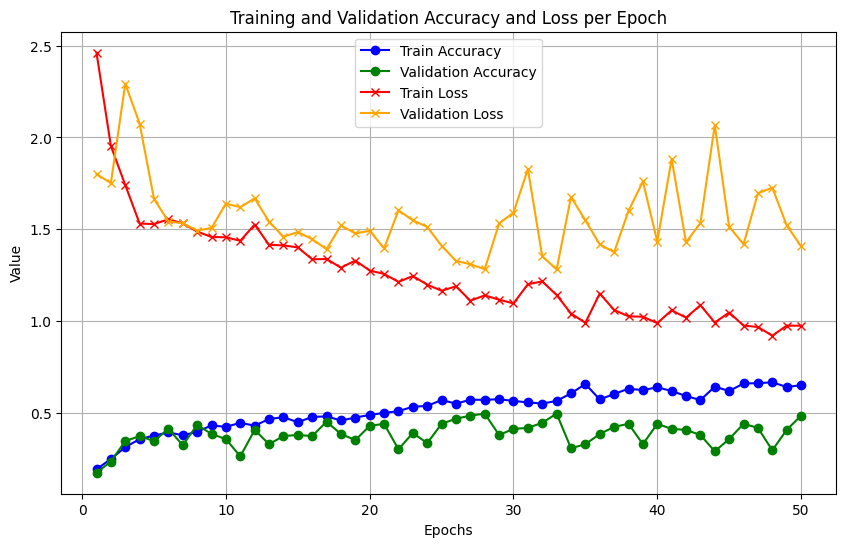

In [ ]:
import matplotlib.pyplot as plt

# I dati dell'accuratezza e della perdita per ogni epoca
epochs = list(range(1, 51))
train_acc = [0.1905, 0.2476, 0.3111, 0.3556, 0.3746, 0.3921, 0.3762, 0.3952, 0.4302, 0.4222, 0.4444, 0.4286,
             0.4651, 0.4746, 0.4476, 0.4762, 0.4794, 0.4571, 0.4730, 0.4873, 0.4984, 0.5079, 0.5317, 0.5365, 0.5683,
             0.5492, 0.5698, 0.5698, 0.5730, 0.5635, 0.5556, 0.5492, 0.5635, 0.6048, 0.6556, 0.5714, 0.6016, 0.6302,
             0.6222, 0.6381, 0.6175, 0.5905, 0.5683, 0.6413, 0.6175, 0.6587, 0.6603, 0.6651, 0.6397, 0.6492]
val_acc = [0.1722, 0.2333, 0.3444, 0.3722, 0.3444, 0.4111, 0.3222, 0.4333, 0.3833, 0.3556, 0.2611, 0.4056, 0.3278,
           0.3722, 0.3778, 0.3722, 0.4500, 0.3833, 0.3500, 0.4278, 0.4389, 0.3000, 0.3889, 0.3333, 0.4389, 0.4667,
           0.4833, 0.4944, 0.3778, 0.4111, 0.4167, 0.4444, 0.4944, 0.3056, 0.3278, 0.3833, 0.4222, 0.4389, 0.3278,
           0.4389, 0.4111, 0.4056, 0.3778, 0.2889, 0.3556, 0.4389, 0.4167, 0.2944, 0.4056, 0.4833]

train_loss = [2.4618, 1.9535, 1.7402, 1.5305, 1.5277, 1.5539, 1.5314, 1.4870, 1.4572, 1.4559, 1.4364, 1.5250, 1.4145,
              1.4116, 1.4004, 1.3358, 1.3371, 1.2900, 1.3288, 1.2742, 1.2560, 1.2125, 1.2444, 1.1975, 1.1643, 1.1883,
              1.1101, 1.1389, 1.1156, 1.0951, 1.1998, 1.2151, 1.1409, 1.0398, 0.9897, 1.1492, 1.0595, 1.0248, 1.0225,
              0.9878, 1.0577, 1.0176, 1.0854, 0.9911, 1.0456, 0.9744, 0.9667, 0.9192, 0.9738, 0.9737]
val_loss = [1.7998, 1.7512, 2.2929, 2.0752, 1.6646, 1.5417, 1.5317, 1.4924, 1.5068, 1.6391, 1.6197, 1.6680, 1.5405,
            1.4586, 1.4840, 1.4453, 1.3907, 1.5203, 1.4767, 1.4912, 1.3953, 1.6024, 1.5481, 1.5123, 1.4094, 1.3271,
            1.3086, 1.2819, 1.5311, 1.5899, 1.8277, 1.3522, 1.2802, 1.6754, 1.5479, 1.4164, 1.3745, 1.5995, 1.7598,
            1.4323, 1.8828, 1.4284, 1.5331, 2.0671, 1.5131, 1.4177, 1.6953, 1.7262, 1.5212, 1.4065]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='green', linestyle='-', marker='o')
plt.plot(epochs, train_loss, label='Train Loss', color='red', linestyle='-', marker='x')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linestyle='-', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training and Validation Accuracy and Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()



Rifaccio questa parte

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

def accuracy(y_hat, y):
    """Calculate the accuracy of predictions."""
    preds = torch.argmax(y_hat, dim=1)
    return (preds == y).float().mean().item()

def train(net, train_loader, val_loader, test_loader, num_epochs, lr, weight_decay=1e-4, device=None, patience=15, min_delta=0.001):
    """
    Trains a model on GPU (if available) with early stopping.

    Args:
        net: the neural network to train.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        test_loader: DataLoader for the test set (not used in early stopping).
        num_epochs: maximum number of epochs.
        lr: learning rate.
        weight_decay: weight decay for the optimizer.
        device: device to run training on.
        patience: number of epochs with no improvement after which training will be stopped.
        min_delta: minimum change in the validation loss to qualify as an improvement.
    """
    # Set device to GPU if available, otherwise CPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Xavier initialization for Linear and Conv2d layers
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print(f'Training on {device}')
    net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = []  # list to store epoch results

    for epoch in range(num_epochs):
        net.train()
        epoch_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()




In [ ]:
train(net, train_loader, val_loader, test_loader, num_epochs=50, lr=0.01)

NameError: name 'net' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import ast
import matplotlib.pyplot as plt
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def accuracy(y_hat, y):
    """Calculate the accuracy of predictions."""
    preds = torch.argmax(y_hat, dim=1)
    return (preds == y).float().mean().item()

def train(net, train_loader, val_loader, test_loader, num_epochs, lr, weight_decay=1e-4,
          device=None, patience=15, min_delta=0.001):
    """
    Trains a model on GPU (if available) with early stopping.

    Args:
        net: the neural network to train.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        test_loader: DataLoader for the test set (not used in early stopping).
        num_epochs: maximum number of epochs.
        lr: learning rate.
        weight_decay: weight decay for the optimizer.
        device: device to run training on.
        patience: number of epochs with no improvement after which training will be stopped.
        min_delta: minimum change in the validation loss to qualify as an improvement.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Xavier initialization for Linear and Conv2d layers
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print(f"Training on {device}")
    net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = []  # list to store epoch results

    for epoch in range(num_epochs):
        net.train()
        epoch_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X.size(0)
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += X.size(0)

            progress_bar.set_postfix(loss=epoch_loss/total, acc=correct/total)

        train_loss = epoch_loss / total
        train_acc = correct / total

        # Validation phase
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += loss_fn(y_hat, y).item() * X.size(0)
                val_correct += (y_hat.argmax(dim=1) == y).sum().item()
                val_total += X.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total

        # Log epoch result
        epoch_result = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        history.append(epoch_result)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        # Early stopping check
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model checkpoint
            torch.save(net.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Save final model and training history
    torch.save(net.state_dict(), 'Jellyfish_Inception.pth')
    print("Final model saved as 'Jellyfish_Inception.pth'")

    with open('training_history.txt', 'w') as f:
        for entry in history:
            f.write(str(entry) + "\n")

    return net

def plot_training_history(history_file='training_history.txt'):
    """
    Reads the training history from a file and plots training and validation loss and accuracy.
    The file should contain one dictionary per line with keys:
    'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'.
    """
    history = []
    with open(history_file, 'r') as f:
        for line in f:
            if line.strip():
                entry = ast.literal_eval(line.strip())
                history.append(entry)

    epochs = [entry['epoch'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]
    train_acc = [entry['train_acc'] for entry in history]
    val_acc = [entry['val_acc'] for entry in history]

    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r-o', label='Train Loss')
    plt.plot(epochs, val_loss, 'b-o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'r-o', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'b-o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Training on cuda


Epoch 1/50: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s, acc=0.17, loss=3.28]


Epoch 1: Train Loss=3.2844, Train Acc=0.1698, Val Loss=126107.2198, Val Acc=0.2000


Epoch 2/50: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s, acc=0.23, loss=2.06]


Epoch 2: Train Loss=2.0608, Train Acc=0.2302, Val Loss=577.7941, Val Acc=0.1722


Epoch 3/50: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s, acc=0.338, loss=1.75]


Epoch 3: Train Loss=1.7544, Train Acc=0.3381, Val Loss=25.2181, Val Acc=0.2278


Epoch 4/50: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s, acc=0.348, loss=1.76]


Epoch 4: Train Loss=1.7586, Train Acc=0.3476, Val Loss=70.2163, Val Acc=0.2222


Epoch 5/50: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s, acc=0.349, loss=1.75]


Epoch 5: Train Loss=1.7458, Train Acc=0.3492, Val Loss=11.7814, Val Acc=0.2667


Epoch 6/50: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s, acc=0.359, loss=1.65]


Epoch 6: Train Loss=1.6465, Train Acc=0.3587, Val Loss=3.5877, Val Acc=0.3944


Epoch 7/50: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s, acc=0.373, loss=1.72]


Epoch 7: Train Loss=1.7221, Train Acc=0.3730, Val Loss=1.6518, Val Acc=0.3944


Epoch 8/50: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s, acc=0.379, loss=1.61]


Epoch 8: Train Loss=1.6079, Train Acc=0.3794, Val Loss=1.5453, Val Acc=0.3667


Epoch 9/50: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s, acc=0.34, loss=1.74]


Epoch 9: Train Loss=1.7382, Train Acc=0.3397, Val Loss=1.7091, Val Acc=0.2500


Epoch 10/50: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s, acc=0.381, loss=1.69]


Epoch 10: Train Loss=1.6868, Train Acc=0.3810, Val Loss=1.7373, Val Acc=0.3389


Epoch 11/50: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s, acc=0.376, loss=1.63]


Epoch 11: Train Loss=1.6334, Train Acc=0.3762, Val Loss=1.4852, Val Acc=0.3889


Epoch 12/50: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s, acc=0.43, loss=1.43]


Epoch 12: Train Loss=1.4268, Train Acc=0.4302, Val Loss=2.5906, Val Acc=0.2778


Epoch 13/50: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s, acc=0.427, loss=1.44]


Epoch 13: Train Loss=1.4357, Train Acc=0.4270, Val Loss=2.6097, Val Acc=0.3611


Epoch 14/50: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s, acc=0.395, loss=1.54]


Epoch 14: Train Loss=1.5362, Train Acc=0.3952, Val Loss=1.3704, Val Acc=0.4833


Epoch 15/50: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s, acc=0.43, loss=1.47]


Epoch 15: Train Loss=1.4700, Train Acc=0.4302, Val Loss=1.5250, Val Acc=0.3167


Epoch 16/50: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s, acc=0.441, loss=1.4]


Epoch 16: Train Loss=1.4042, Train Acc=0.4413, Val Loss=1.6433, Val Acc=0.2111


Epoch 17/50: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s, acc=0.41, loss=1.45]


Epoch 17: Train Loss=1.4526, Train Acc=0.4095, Val Loss=1.5952, Val Acc=0.2833


Epoch 18/50: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s, acc=0.421, loss=1.47]


Epoch 18: Train Loss=1.4719, Train Acc=0.4206, Val Loss=1.5539, Val Acc=0.3556


Epoch 19/50: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s, acc=0.424, loss=1.48]


Epoch 19: Train Loss=1.4817, Train Acc=0.4238, Val Loss=1.5383, Val Acc=0.3333


Epoch 20/50: 100%|██████████| 10/10 [00:04<00:00,  2.24it/s, acc=0.443, loss=1.44]


Epoch 20: Train Loss=1.4407, Train Acc=0.4429, Val Loss=1.3565, Val Acc=0.4556


Epoch 21/50: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s, acc=0.462, loss=1.42]


Epoch 21: Train Loss=1.4157, Train Acc=0.4619, Val Loss=1.4690, Val Acc=0.3389


Epoch 22/50: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s, acc=0.405, loss=1.52]


Epoch 22: Train Loss=1.5163, Train Acc=0.4048, Val Loss=1.6332, Val Acc=0.2722


Epoch 23/50: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s, acc=0.476, loss=1.37]


Epoch 23: Train Loss=1.3749, Train Acc=0.4762, Val Loss=1.6964, Val Acc=0.3333


Epoch 24/50: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s, acc=0.465, loss=1.38]


Epoch 24: Train Loss=1.3770, Train Acc=0.4651, Val Loss=1.6058, Val Acc=0.2778


Epoch 25/50: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s, acc=0.519, loss=1.32]


Epoch 25: Train Loss=1.3180, Train Acc=0.5190, Val Loss=1.6145, Val Acc=0.3500


Epoch 26/50: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s, acc=0.476, loss=1.35]


Epoch 26: Train Loss=1.3515, Train Acc=0.4762, Val Loss=1.4792, Val Acc=0.4167


Epoch 27/50: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s, acc=0.502, loss=1.28]


Epoch 27: Train Loss=1.2831, Train Acc=0.5016, Val Loss=1.4194, Val Acc=0.3944


Epoch 28/50: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s, acc=0.544, loss=1.21]


Epoch 28: Train Loss=1.2108, Train Acc=0.5444, Val Loss=1.5414, Val Acc=0.3389


Epoch 29/50: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s, acc=0.516, loss=1.24]


Epoch 29: Train Loss=1.2428, Train Acc=0.5159, Val Loss=1.3571, Val Acc=0.4778


Epoch 30/50: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s, acc=0.505, loss=1.27]


Epoch 30: Train Loss=1.2734, Train Acc=0.5048, Val Loss=1.3977, Val Acc=0.4667


Epoch 31/50: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s, acc=0.538, loss=1.23]


Epoch 31: Train Loss=1.2269, Train Acc=0.5381, Val Loss=1.5423, Val Acc=0.3944


Epoch 32/50: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s, acc=0.556, loss=1.16]


Epoch 32: Train Loss=1.1602, Train Acc=0.5556, Val Loss=1.5187, Val Acc=0.4111


Epoch 33/50: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s, acc=0.576, loss=1.1]


Epoch 33: Train Loss=1.0979, Train Acc=0.5762, Val Loss=1.5252, Val Acc=0.4722


Epoch 34/50: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s, acc=0.581, loss=1.12]


Epoch 34: Train Loss=1.1234, Train Acc=0.5810, Val Loss=1.3486, Val Acc=0.4778


Epoch 35/50: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s, acc=0.584, loss=1.15]


Epoch 35: Train Loss=1.1506, Train Acc=0.5841, Val Loss=1.6253, Val Acc=0.3833


Epoch 36/50: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s, acc=0.594, loss=1.11]


Epoch 36: Train Loss=1.1090, Train Acc=0.5937, Val Loss=2.1423, Val Acc=0.2833


Epoch 37/50: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s, acc=0.584, loss=1.14]


Epoch 37: Train Loss=1.1398, Train Acc=0.5841, Val Loss=1.6382, Val Acc=0.3278


Epoch 38/50: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s, acc=0.57, loss=1.13]


Epoch 38: Train Loss=1.1303, Train Acc=0.5698, Val Loss=1.6627, Val Acc=0.4333


Epoch 39/50: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s, acc=0.584, loss=1.15]


Epoch 39: Train Loss=1.1487, Train Acc=0.5841, Val Loss=1.3803, Val Acc=0.4556


Epoch 40/50: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s, acc=0.63, loss=1.03]


Epoch 40: Train Loss=1.0329, Train Acc=0.6302, Val Loss=1.3091, Val Acc=0.5222


Epoch 41/50: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s, acc=0.619, loss=1.1]


Epoch 41: Train Loss=1.1037, Train Acc=0.6190, Val Loss=1.8649, Val Acc=0.3278


Epoch 42/50: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s, acc=0.624, loss=1]


Epoch 42: Train Loss=1.0000, Train Acc=0.6238, Val Loss=1.3118, Val Acc=0.5667


Epoch 43/50: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s, acc=0.567, loss=1.1]


Epoch 43: Train Loss=1.0998, Train Acc=0.5667, Val Loss=1.4283, Val Acc=0.5056


Epoch 44/50: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s, acc=0.635, loss=1.09]


Epoch 44: Train Loss=1.0907, Train Acc=0.6349, Val Loss=1.6584, Val Acc=0.4056


Epoch 45/50: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s, acc=0.61, loss=1.04]


Epoch 45: Train Loss=1.0403, Train Acc=0.6095, Val Loss=1.3179, Val Acc=0.5389


Epoch 46/50: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s, acc=0.64, loss=0.998]


Epoch 46: Train Loss=0.9976, Train Acc=0.6397, Val Loss=1.3598, Val Acc=0.5222


Epoch 47/50: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s, acc=0.63, loss=1.01]


Epoch 47: Train Loss=1.0117, Train Acc=0.6302, Val Loss=1.5975, Val Acc=0.3556


Epoch 48/50: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s, acc=0.632, loss=0.988]


Epoch 48: Train Loss=0.9882, Train Acc=0.6317, Val Loss=1.4264, Val Acc=0.4278


Epoch 49/50: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s, acc=0.622, loss=1.05]


Epoch 49: Train Loss=1.0479, Train Acc=0.6222, Val Loss=1.4905, Val Acc=0.4889


Epoch 50/50: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s, acc=0.646, loss=0.944]


Epoch 50: Train Loss=0.9440, Train Acc=0.6460, Val Loss=1.5213, Val Acc=0.4667
Final model saved as 'Jellyfish_Inception.pth'


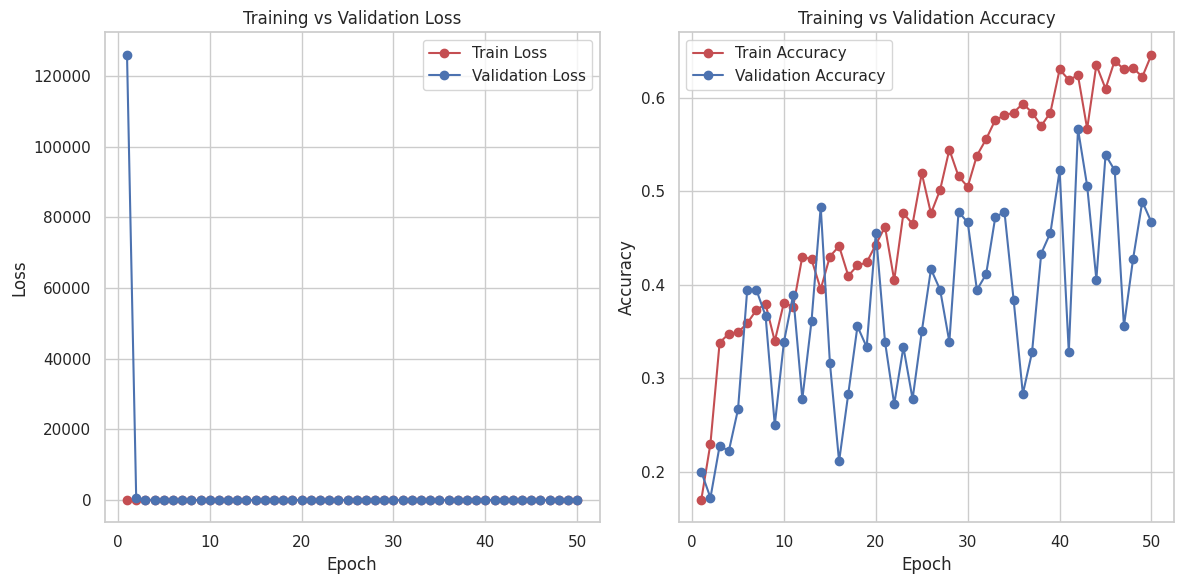

In [ ]:
net = train(net, train_loader, val_loader, test_loader, num_epochs=50, lr=0.01, patience=20)
plot_training_history()
#learning rate
#batch size


**ResNet**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Shortcut connection to match dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Pass input through the two convolutional layers
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
        # Apply ReLU activation to the result
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # ResNet layers composed of BasicBlocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Final classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Create a ResNet layer by stacking `num_blocks` BasicBlocks
        layers = []
        # First block may change input/output dimensions
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        # Remaining blocks keep the same dimensions
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through initial convolutional layer
        out = F.relu(self.bn1(self.conv1(x)))
        # Pass through each ResNet layer
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Perform global average pooling
        out = self.avg_pool(out)
        # Flatten for the fully connected layer
        out = out.view(out.size(0), -1)
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

# Function to create a ResNet-18 as an example
def ResNet18(num_classes=10):
    # The number of blocks per layer for ResNet-18 is [2, 2, 2, 2]
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

# Example usage
model = ResNet18(num_classes=6)  # Adjust `num_classes` according to your dataset
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define a training function similar to what you had before
def train_resnet(net, train_loader, val_loader, test_loader, num_epochs, lr, weight_decay=1e-4, device=None):
    """
    Train a ResNet model.
    """
    # If no device is specified, use GPU if available, otherwise CPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Send the model to the device
    net.to(device)

    # Define the optimizer and loss function
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    # Track the best validation accuracy and loss
    best_val_loss = float('inf')
    best_val_acc = 0.0
    history = []  # To store epoch results

    for epoch in range(num_epochs):
        # Training phase
        net.train()
        train_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            # Update training metrics
            train_loss += loss.item() * X.size(0)
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += X.size(0)
            progress_bar.set_postfix(loss=train_loss/total, acc=correct/total)

        # Validation phase
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += loss_fn(y_hat, y).item() * X.size(0)
                val_correct += (y_hat.argmax(dim=1) == y).sum().item()
                val_total += X.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total

        # Print epoch results
        print(f"Epoch {epoch+1}: Train Loss={train_loss/total:.4f}, Train Acc={correct/total:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        # Track best validation metrics
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            # Save the best model
            torch.save(net.state_dict(), 'best_resnet.pth')

        # Append to history
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss / total,
            'train_acc': correct / total,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    # Save the final model
    torch.save(net.state_dict(), 'final_resnet.pth')
    print("Final model saved as 'final_resnet.pth'")

    return net, history

# Example usage
# Assume you have train_loader, val_loader, and test_loader already defined
# For example, if using your existing DataLoader setup, you can reuse those directly.
# And you can use the ResNet18 implementation defined earlier.
model = ResNet18(num_classes=6)
trained_model, training_history = train_resnet(model, train_loader, val_loader, test_loader, num_epochs=50, lr=0.001)


Epoch 1/50: 100%|██████████| 10/10 [00:35<00:00,  3.52s/it, acc=0.276, loss=2.1]


Epoch 1: Train Loss=2.1031, Train Acc=0.2762, Val Loss=8.0544, Val Acc=0.1722


Epoch 2/50: 100%|██████████| 10/10 [00:32<00:00,  3.29s/it, acc=0.398, loss=1.48]


Epoch 2: Train Loss=1.4833, Train Acc=0.3984, Val Loss=5.5597, Val Acc=0.2333


Epoch 3/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.408, loss=1.44]


Epoch 3: Train Loss=1.4390, Train Acc=0.4079, Val Loss=2.2177, Val Acc=0.3556


Epoch 4/50: 100%|██████████| 10/10 [00:33<00:00,  3.34s/it, acc=0.416, loss=1.44]


Epoch 4: Train Loss=1.4359, Train Acc=0.4159, Val Loss=1.6112, Val Acc=0.4444


Epoch 5/50: 100%|██████████| 10/10 [00:33<00:00,  3.30s/it, acc=0.451, loss=1.36]


Epoch 5: Train Loss=1.3557, Train Acc=0.4508, Val Loss=1.4211, Val Acc=0.4056


Epoch 6/50: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it, acc=0.43, loss=1.36]


Epoch 6: Train Loss=1.3584, Train Acc=0.4302, Val Loss=1.6692, Val Acc=0.4389


Epoch 7/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.494, loss=1.28]


Epoch 7: Train Loss=1.2804, Train Acc=0.4937, Val Loss=1.3565, Val Acc=0.3944


Epoch 8/50: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it, acc=0.47, loss=1.33]


Epoch 8: Train Loss=1.3336, Train Acc=0.4698, Val Loss=1.5043, Val Acc=0.4056


Epoch 9/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.459, loss=1.3]


Epoch 9: Train Loss=1.3008, Train Acc=0.4587, Val Loss=1.3213, Val Acc=0.5333


Epoch 10/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.532, loss=1.25]


Epoch 10: Train Loss=1.2509, Train Acc=0.5317, Val Loss=1.2899, Val Acc=0.5222


Epoch 11/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.497, loss=1.25]


Epoch 11: Train Loss=1.2550, Train Acc=0.4968, Val Loss=1.2885, Val Acc=0.4722


Epoch 12/50: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it, acc=0.502, loss=1.26]


Epoch 12: Train Loss=1.2560, Train Acc=0.5016, Val Loss=1.2997, Val Acc=0.5222


Epoch 13/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.508, loss=1.25]


Epoch 13: Train Loss=1.2491, Train Acc=0.5079, Val Loss=1.4647, Val Acc=0.4722


Epoch 14/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.51, loss=1.19]


Epoch 14: Train Loss=1.1899, Train Acc=0.5095, Val Loss=1.4418, Val Acc=0.4778


Epoch 15/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.479, loss=1.25]


Epoch 15: Train Loss=1.2504, Train Acc=0.4794, Val Loss=1.4317, Val Acc=0.5167


Epoch 16/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.535, loss=1.18]


Epoch 16: Train Loss=1.1820, Train Acc=0.5349, Val Loss=1.3346, Val Acc=0.5056


Epoch 17/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.522, loss=1.19]


Epoch 17: Train Loss=1.1881, Train Acc=0.5222, Val Loss=1.3126, Val Acc=0.5000


Epoch 18/50: 100%|██████████| 10/10 [00:33<00:00,  3.30s/it, acc=0.505, loss=1.2]


Epoch 18: Train Loss=1.1992, Train Acc=0.5048, Val Loss=1.3384, Val Acc=0.4667


Epoch 19/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.514, loss=1.17]


Epoch 19: Train Loss=1.1687, Train Acc=0.5143, Val Loss=1.2491, Val Acc=0.5556


Epoch 20/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.54, loss=1.19]


Epoch 20: Train Loss=1.1904, Train Acc=0.5397, Val Loss=1.3148, Val Acc=0.4889


Epoch 21/50: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it, acc=0.525, loss=1.21]


Epoch 21: Train Loss=1.2128, Train Acc=0.5254, Val Loss=1.2857, Val Acc=0.5500


Epoch 22/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.5, loss=1.23]


Epoch 22: Train Loss=1.2263, Train Acc=0.5000, Val Loss=1.2672, Val Acc=0.5056


Epoch 23/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.533, loss=1.18]


Epoch 23: Train Loss=1.1770, Train Acc=0.5333, Val Loss=1.3175, Val Acc=0.4778


Epoch 24/50: 100%|██████████| 10/10 [00:33<00:00,  3.34s/it, acc=0.529, loss=1.12]


Epoch 24: Train Loss=1.1190, Train Acc=0.5286, Val Loss=1.2638, Val Acc=0.5556


Epoch 25/50: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it, acc=0.556, loss=1.14]


Epoch 25: Train Loss=1.1415, Train Acc=0.5556, Val Loss=1.3118, Val Acc=0.4722


Epoch 26/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.54, loss=1.17]


Epoch 26: Train Loss=1.1667, Train Acc=0.5397, Val Loss=1.2610, Val Acc=0.5278


Epoch 27/50: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it, acc=0.535, loss=1.11]


Epoch 27: Train Loss=1.1119, Train Acc=0.5349, Val Loss=1.2188, Val Acc=0.5889


Epoch 28/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.571, loss=1.11]


Epoch 28: Train Loss=1.1062, Train Acc=0.5714, Val Loss=1.2193, Val Acc=0.5778


Epoch 29/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.57, loss=1.09]


Epoch 29: Train Loss=1.0850, Train Acc=0.5698, Val Loss=1.1842, Val Acc=0.5222


Epoch 30/50: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it, acc=0.579, loss=1.1]


Epoch 30: Train Loss=1.1040, Train Acc=0.5794, Val Loss=1.2050, Val Acc=0.5056


Epoch 31/50: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it, acc=0.535, loss=1.18]


Epoch 31: Train Loss=1.1756, Train Acc=0.5349, Val Loss=1.4072, Val Acc=0.4889


Epoch 32/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.579, loss=1.07]


Epoch 32: Train Loss=1.0700, Train Acc=0.5794, Val Loss=1.2983, Val Acc=0.5389


Epoch 33/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.551, loss=1.08]


Epoch 33: Train Loss=1.0804, Train Acc=0.5508, Val Loss=1.2118, Val Acc=0.5833


Epoch 34/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.552, loss=1.11]


Epoch 34: Train Loss=1.1059, Train Acc=0.5524, Val Loss=1.1559, Val Acc=0.5889


Epoch 35/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.61, loss=1.08]


Epoch 35: Train Loss=1.0789, Train Acc=0.6095, Val Loss=1.2428, Val Acc=0.5944


Epoch 36/50: 100%|██████████| 10/10 [00:33<00:00,  3.30s/it, acc=0.619, loss=1.07]


Epoch 36: Train Loss=1.0727, Train Acc=0.6190, Val Loss=1.1738, Val Acc=0.6111


Epoch 37/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.592, loss=1.05]


Epoch 37: Train Loss=1.0462, Train Acc=0.5921, Val Loss=1.1529, Val Acc=0.5722


Epoch 38/50: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it, acc=0.573, loss=1.08]


Epoch 38: Train Loss=1.0823, Train Acc=0.5730, Val Loss=1.1397, Val Acc=0.6056


Epoch 39/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.616, loss=0.973]


Epoch 39: Train Loss=0.9729, Train Acc=0.6159, Val Loss=1.1495, Val Acc=0.6167


Epoch 40/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.614, loss=1.02]


Epoch 40: Train Loss=1.0172, Train Acc=0.6143, Val Loss=1.1190, Val Acc=0.6000


Epoch 41/50: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it, acc=0.629, loss=0.964]


Epoch 41: Train Loss=0.9639, Train Acc=0.6286, Val Loss=1.1827, Val Acc=0.5222


Epoch 42/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.627, loss=1.02]


Epoch 42: Train Loss=1.0217, Train Acc=0.6270, Val Loss=1.1778, Val Acc=0.5611


Epoch 43/50: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it, acc=0.603, loss=0.988]


Epoch 43: Train Loss=0.9877, Train Acc=0.6032, Val Loss=1.1345, Val Acc=0.5556


Epoch 44/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.6, loss=1.01]


Epoch 44: Train Loss=1.0051, Train Acc=0.6000, Val Loss=1.1485, Val Acc=0.5944


Epoch 45/50: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it, acc=0.6, loss=1.02]


Epoch 45: Train Loss=1.0248, Train Acc=0.6000, Val Loss=1.1343, Val Acc=0.5722


Epoch 46/50: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it, acc=0.641, loss=1.01]


Epoch 46: Train Loss=1.0131, Train Acc=0.6413, Val Loss=1.2923, Val Acc=0.4944


Epoch 47/50: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it, acc=0.594, loss=1.11]


Epoch 47: Train Loss=1.1085, Train Acc=0.5937, Val Loss=1.5030, Val Acc=0.5222


Epoch 48/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.562, loss=1.09]


Epoch 48: Train Loss=1.0867, Train Acc=0.5619, Val Loss=1.1170, Val Acc=0.6111


Epoch 49/50: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it, acc=0.605, loss=1.01]


Epoch 49: Train Loss=1.0150, Train Acc=0.6048, Val Loss=1.2320, Val Acc=0.5333


Epoch 50/50: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it, acc=0.586, loss=0.995]


Epoch 50: Train Loss=0.9954, Train Acc=0.5857, Val Loss=1.1048, Val Acc=0.6167
Final model saved as 'final_resnet.pth'


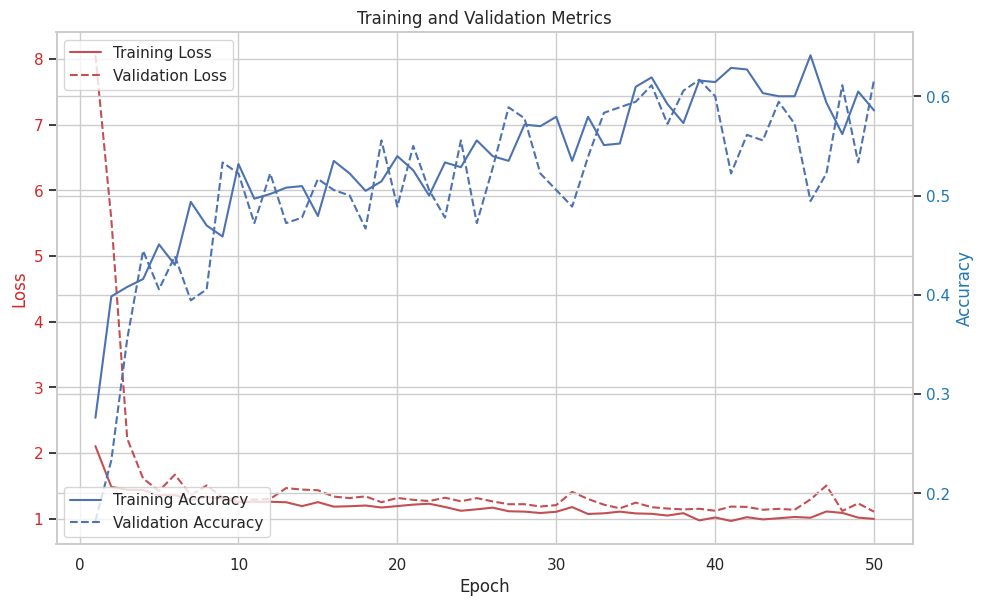

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation loss and accuracy.
    The list `history` should contain dictionaries with the keys:
    'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'.
    """
    # Extract epochs and metrics from history
    epochs = [entry['epoch'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]
    train_acc = [entry['train_acc'] for entry in history]
    val_acc = [entry['val_acc'] for entry in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss on the left y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_loss, 'r-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r--', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper left')

    # Create a twin y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.legend(loc='lower left')

    fig.tight_layout()
    plt.title("Training and Validation Metrics")
    plt.show()

# Call the function to display the plot
plot_training_history(training_history)


### **Analysis of ResNet’s Performance against GoogleNet and Potential Causes**  

From the results obtained, ResNet-18 demonstrated more stable and accurate performance compared to GoogLeNet in jellyfish classification. The key factors contributing to this difference can be attributed to various aspects of architecture and generalization capability:  

- **Residual Connections and Training Stability**  
  ResNet employs skip connections, which allow certain layers to be bypassed, mitigating the vanishing gradient problem. This enhances the flow of information through deeper layers, enabling the model to **learn more effectively without performance degradation**. In contrast, GoogLeNet, despite its efficiency through Inception modules, may experience greater instability in optimization, particularly on datasets with high variability.  

- **Better Generalization and Reduced Overfitting**  
  ResNet exhibited a smaller gap between training and validation accuracy, indicating **better generalization capability**. On the other hand, GoogLeNet showed a stronger tendency toward overfitting, likely due to its more complex structure, which captures finer details but may adapt too closely to training data.  

- **Smoother and More Reliable Convergence**  
  Throughout training, ResNet displayed a more consistent and stable learning curve, whereas GoogLeNet exhibited more pronounced fluctuations between epochs. This suggests that **ResNet handles optimization more effectively**, facilitating a **more predictable and less hyperparameter-sensitive convergence**.  

- **Robustness to Dataset Variability**  
  The jellyfish dataset presents significant variations in **orientation, and lighting conditions**. ResNet, with its more hierarchical and deep architecture, appeared to capture the most relevant features for classification, making it more robust. In contrast, GoogLeNet, due to its reliance on multi-scale feature extraction, seemed more sensitive to local variations within images.  

